<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/Training/EVA4_S2_mobilnet_v2_transfer_learning_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load standard Libraries, Load Drive, Load project modules**

In [1]:
pip install torch-lr-finder

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

In [31]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders

In [6]:
from Modules import *

Calaculate mean and standard deviation for the data

In [ ]:
find_mean_standard_deviation("/content/final_images/")

['Small QuadCopters', 'Winged Drones', 'Large QuadCopters', 'Flying Birds']
[0.53713346 0.58979464 0.62127595] [0.36370101 0.41305828 0.47454762] [0.27420551 0.25534403 0.29759673] 1898777428


In [7]:
split_test_train_data('/content/final_images', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6421
3309
3097
4609


Load images in to DataSet and also perform data transforms

In [10]:
batch_size = 192
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.53713346, 0.58979464, 0.62127595],[0.27420551, 0.25534403, 0.29759673])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.53713346, 0.58979464, 0.62127595],[0.27420551, 0.25534403, 0.29759673])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= batch_size, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= batch_size,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

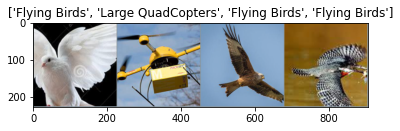

In [47]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow_save(out, save_as="sample.jpg",title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [12]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Find hyper parameter lr value using LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


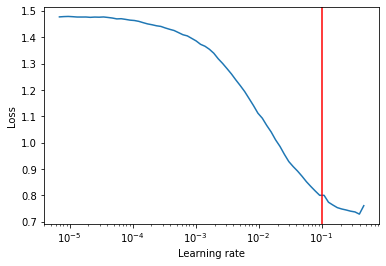

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.01, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [15]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8366 Acc: 0.7008
val Loss: 0.4908 Acc: 0.8621

Epoch 1/4
----------
train Loss: 0.5482 Acc: 0.8227
val Loss: 0.3764 Acc: 0.8866

Epoch 2/4
----------
train Loss: 0.4760 Acc: 0.8403
val Loss: 0.3273 Acc: 0.8996

Epoch 3/4
----------
train Loss: 0.4504 Acc: 0.8401
val Loss: 0.3081 Acc: 0.8990

Epoch 4/4
----------
train Loss: 0.4264 Acc: 0.8484
val Loss: 0.2902 Acc: 0.9028

Training complete in 5m 13s
Best val Acc: 0.902849


  pip install torch-lr-finder -v --global-option="amp"


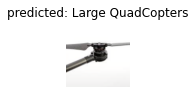

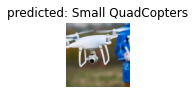

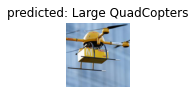

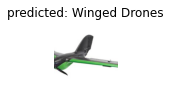

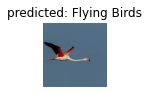

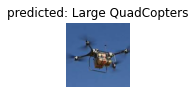

In [32]:
visualize_model(model_res, dataloaders, class_names, device,6,"visualize_1.jpg")

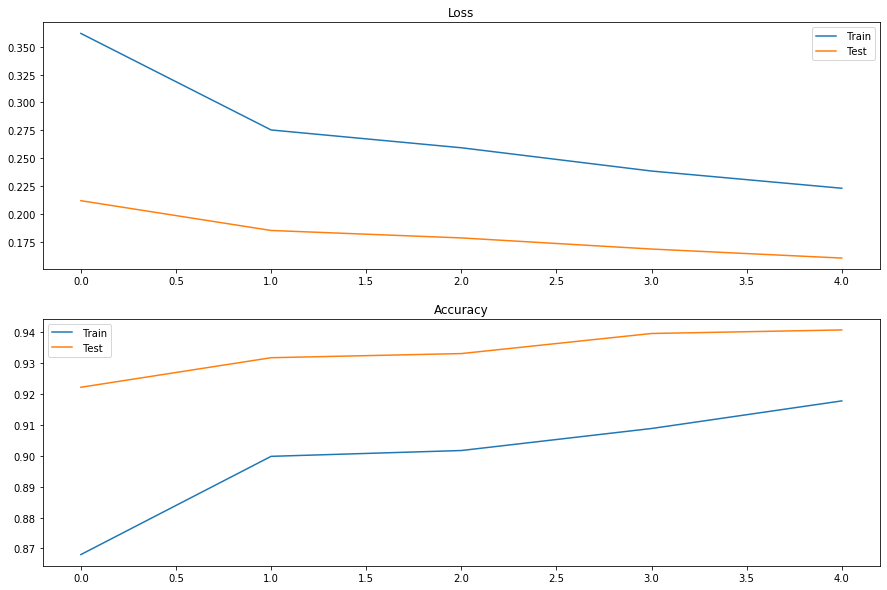

In [33]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [20]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


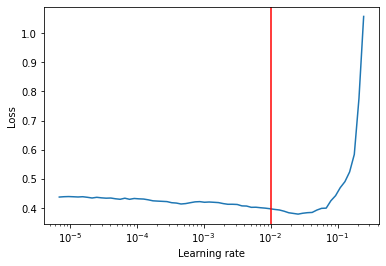

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [22]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25,
                                          pct_start=0.2, div_factor=10, final_div_factor=100)

In [23]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3620 Acc: 0.8680
val Loss: 0.2118 Acc: 0.9222

Epoch 1/4
----------
train Loss: 0.2753 Acc: 0.8998
val Loss: 0.1850 Acc: 0.9317

Epoch 2/4
----------
train Loss: 0.2593 Acc: 0.9017
val Loss: 0.1784 Acc: 0.9331

Epoch 3/4
----------
train Loss: 0.2384 Acc: 0.9088
val Loss: 0.1684 Acc: 0.9396

Epoch 4/4
----------
train Loss: 0.2230 Acc: 0.9178
val Loss: 0.1603 Acc: 0.9407

Training complete in 6m 7s
Best val Acc: 0.940715


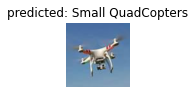

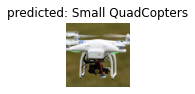

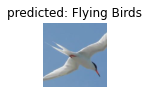

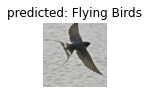

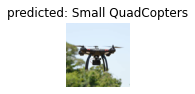

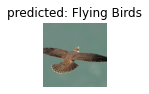

In [24]:
visualize_model(model_res, dataloaders, class_names, device,6,"visualize_2.jpg")
plt.ioff()
plt.show()

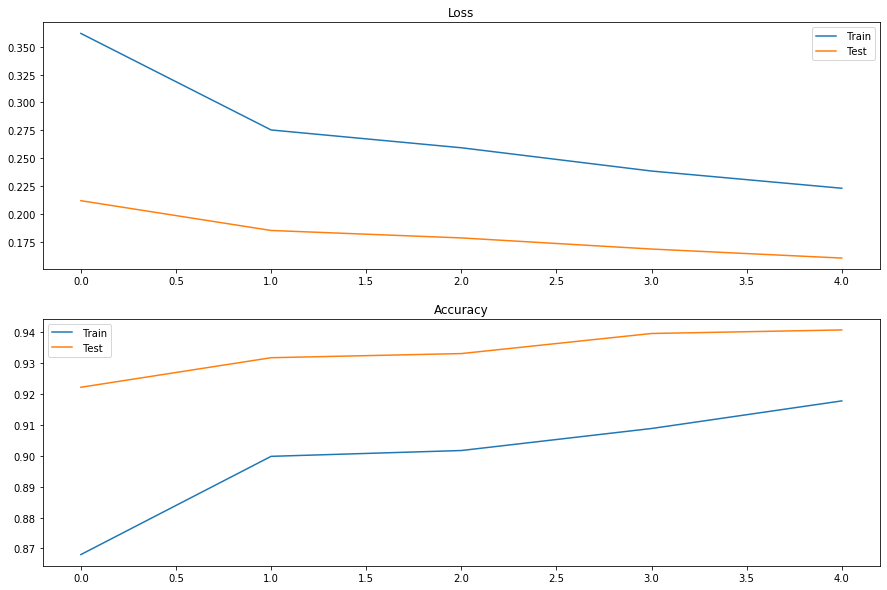

In [34]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

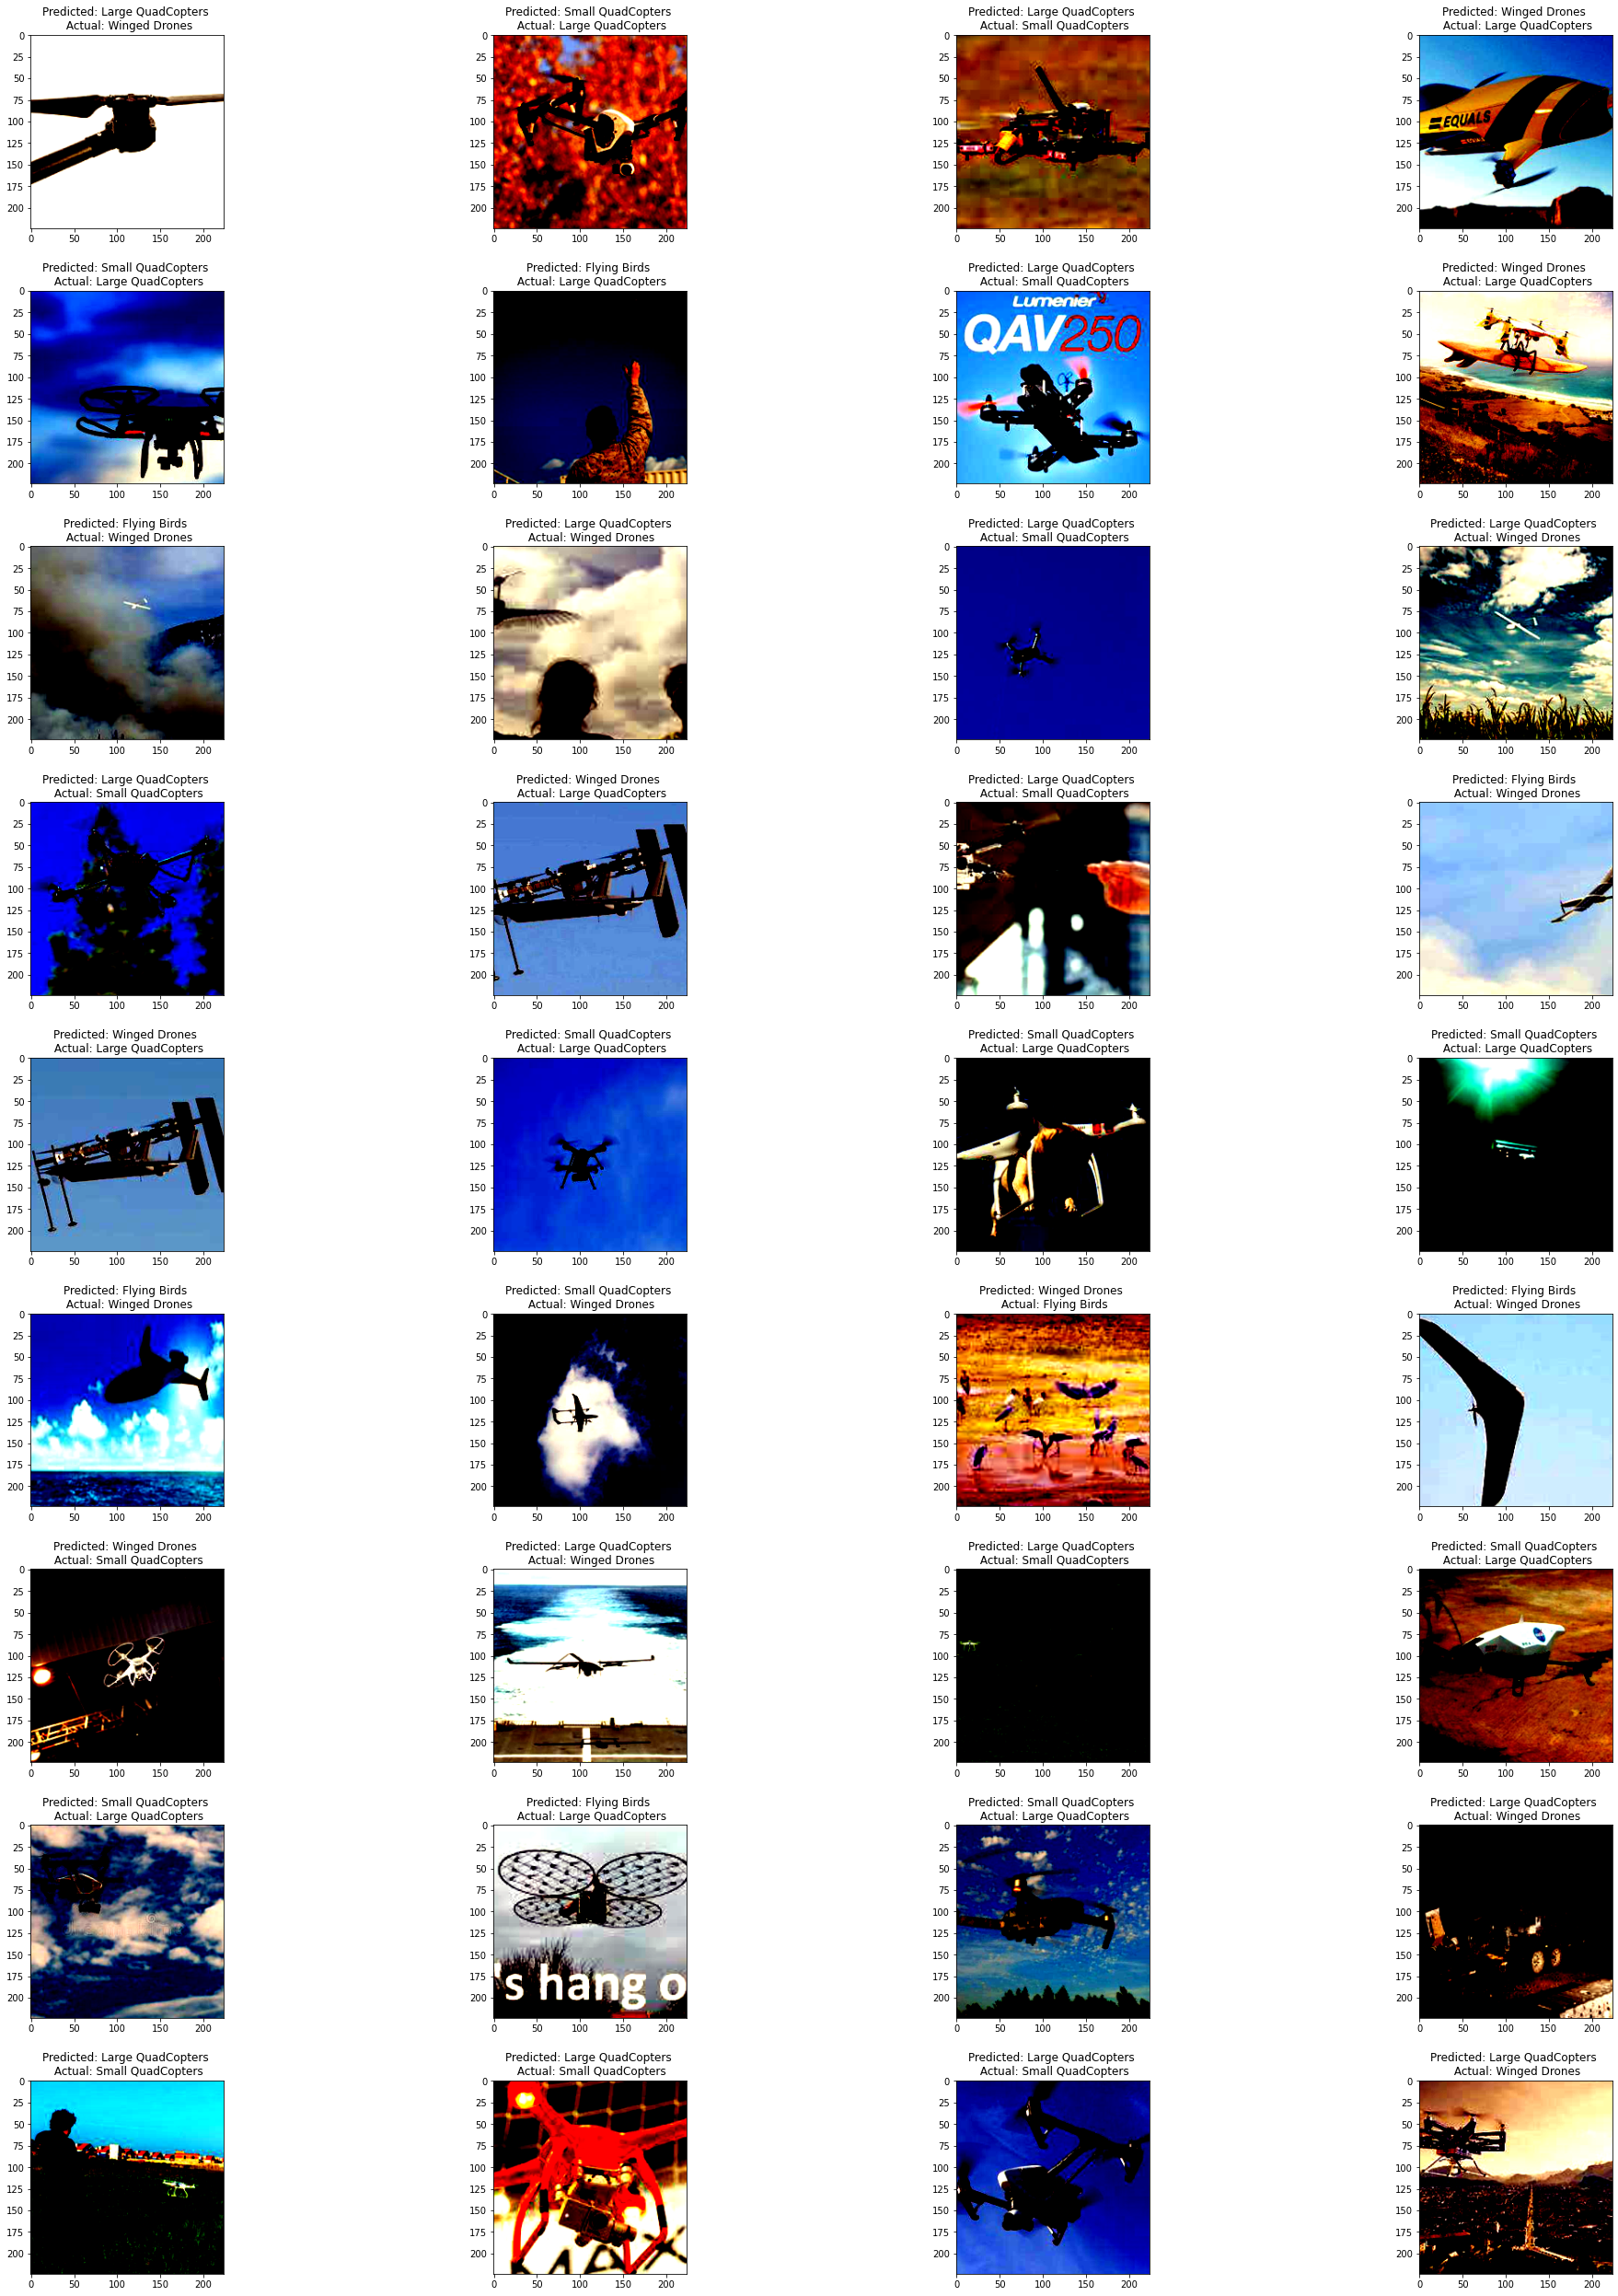

In [35]:
ShowMissclassifiedImages(model_final, dataloaders, class_names, device,save_as="misclassified.jpg")

# 9. Saving Model

In [39]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v5.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v5.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v5.pt')